In [3]:
import pandas as pd
import csv


In [6]:
df = pd.read_csv("/content/new_test.csv")

In [7]:
df.head(5)

,id,statement,Label,len,label
0,1,Building a wall on the U.S.-Mexico border will...,True,68,1
1,2,Wisconsin is on pace to double the number of l...,False,63,0
2,3,Says John McCain has done nothing to help the ...,False,51,0
3,4,Suzanne Bonamici supports a plan that will cut...,True,85,1
4,5,When asked by a reporter whether hes at the ce...,False,127,0


In [8]:
df.isnull().sum()

id           0
statement    0
Label        0
len          0
label        0
dtype: int64

In [9]:
X=df["statement"] #considering text and title as X

In [10]:
Y = df['label']

In [11]:
print(Y)

0        1
1        0
2        0
3        1
4        0
        ..
11496    1
11497    1
11498    1
11499    0
11500    0
Name: label, Length: 11501, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y ,test_size = 0.2, random_state = 10)

In [13]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.4 MB/s eta 0:00:00


In [14]:
from transformers import AutoTokenizer
def tokenize(X):
    X = tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [15]:
X_train_tokens = tokenize(X_train)
X_test_tokens = tokenize(X_test)

In [16]:
print(X_train_tokens)
#print(X_test_tokens)

{'input_ids': <tf.Tensor: shape=(9200, 100), dtype=int32, numpy=
array([[  101, 10035,  2360, ...,     0,     0,     0],
       [  101,  2343, 13857, ...,     0,     0,     0],
       [  101,  2057,  3726, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2228, ...,     0,     0,     0],
       [  101,  2758,  6365, ...,     0,     0,     0],
       [  101,  2758, 10210, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(9200, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


In [17]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel

In [18]:
Length = 100
def get_model():
    dropout_rate = 0.2
    input_ids = Input(shape = (Length,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (Length,), dtype = tf.int32, name = 'input_mask')
    embeddings = bert([input_ids, input_mask])[1] #pooler output
    print(embeddings)
    out = Dropout(0.2)(embeddings)
    #64 units dense layer
    out = Dense(64,activation = 'relu')(out)
    out = Dropout(0.2)(out)
    y = Dense(1,activation = 'sigmoid')(out)
    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
   #define optimizer
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
    #complile the model
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
    return model

In [19]:
pip install keras-rectified-adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.20.0-py3-none-any.whl size=8272 sha256=824fa746061bc1dc56060bf6aa29d3e8581421c1ee6f58ea9e1bba653bb6ef52
  Stored in directory: /root/.cache/pip/wheels/28/1c/f2/1554bc7e22650af3ed067be67cca780212fac6955a272ca815
Successfully built keras-rectified-adam


In [20]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")


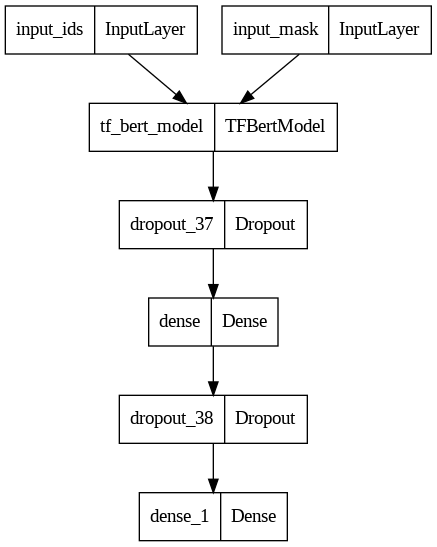

In [21]:
model = get_model()
tf.keras.utils.plot_model(model)

In [22]:
from keras.callbacks import EarlyStopping

In [30]:
history = model.fit(x = {'input_ids':X_test_tokens['input_ids'],'input_mask':X_test_tokens['attention_mask']}, 
                    y = Y_test, epochs=3, validation_split = 0.2, batch_size = 16, 
                    callbacks=[EarlyStopping( monitor='val_accuracy' ,mode='max', patience=3,verbose=True,restore_best_weights=True)])

Epoch 1/3
115/115 [==============================] - 44s 383ms/step - loss: 0.6354 - accuracy: 0.6397 - val_loss: 0.6915 - val_accuracy: 0.5618
Epoch 2/3
115/115 [==============================] - 42s 368ms/step - loss: 0.6361 - accuracy: 0.6353 - val_loss: 0.6978 - val_accuracy: 0.5553
Epoch 3/3
115/115 [==============================] - 44s 380ms/step - loss: 0.6053 - accuracy: 0.6766 - val_loss: 0.7128 - val_accuracy: 0.5705


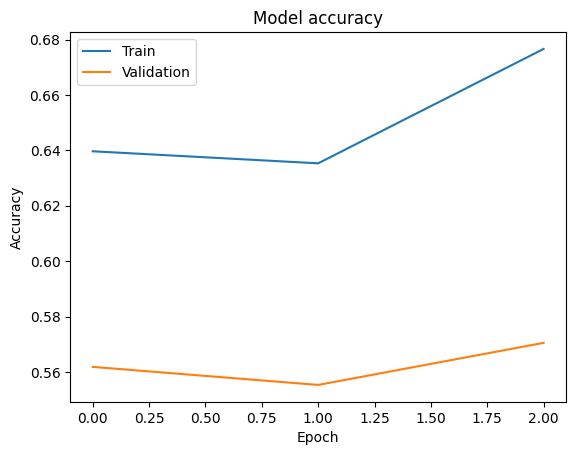

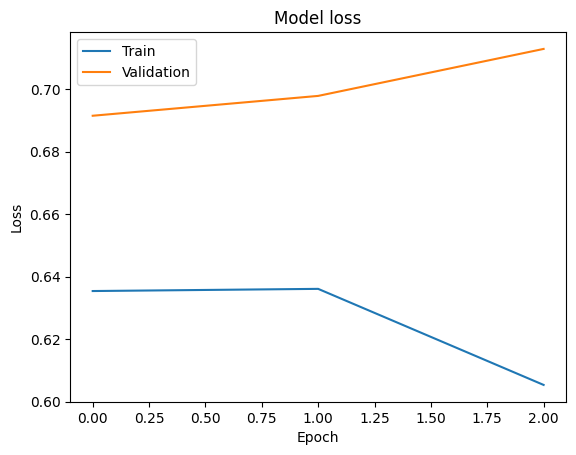

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [34]:
import numpy as np


In [35]:
yhat = np.where(model.predict({ 'input_ids' : X_test_tokens['input_ids'] , 'input_mask' : X_test_tokens['attention_mask']}) >=0.5,1,0)

72/72 [==============================] - 16s 221ms/step


In [36]:
from sklearn.metrics import accuracy_score, f1_score

# Calculate the accuracy
accuracy = accuracy_score(Y_test, yhat)
print('Accuracy:', accuracy)

# Calculate the F1-score
f1score = f1_score(Y_test, yhat)
print('F1-score:', f1score)


Accuracy: 0.6970882225119513
F1-score: 0.7525736599219026


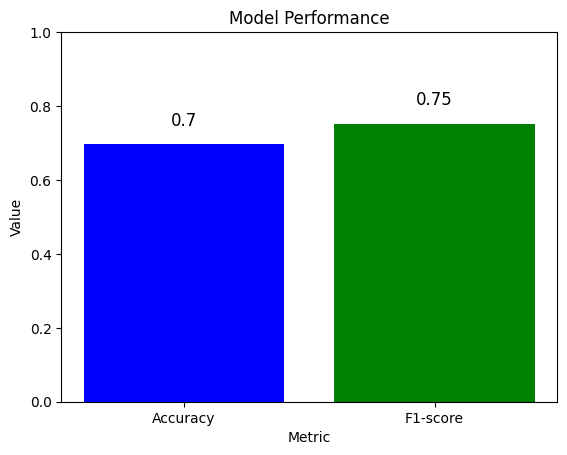

In [37]:
import matplotlib.pyplot as plt

# Calculate the accuracy and F1-score
accuracy = accuracy_score(Y_test, yhat)
f1score = f1_score(Y_test, yhat)

# Create a bar chart
metrics = ['Accuracy', 'F1-score']
values = [accuracy, f1score]

fig, ax = plt.subplots()
ax.bar(metrics, values, color=['blue', 'green'])
ax.set_title('Model Performance')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_ylim(0, 1)

# Show the values on the bars
for i, v in enumerate(values):
    ax.text(i, v + 0.05, str(round(v, 2)), ha='center', fontsize=12)

plt.show()



In [38]:
from sklearn.metrics import classification_report


In [39]:
print(classification_report(Y_test,yhat))

              precision    recall  f1-score   support

           0       0.73      0.52      0.61      1043
           1       0.68      0.84      0.75      1258

    accuracy                           0.70      2301
   macro avg       0.71      0.68      0.68      2301
weighted avg       0.70      0.70      0.69      2301



<Axes: >

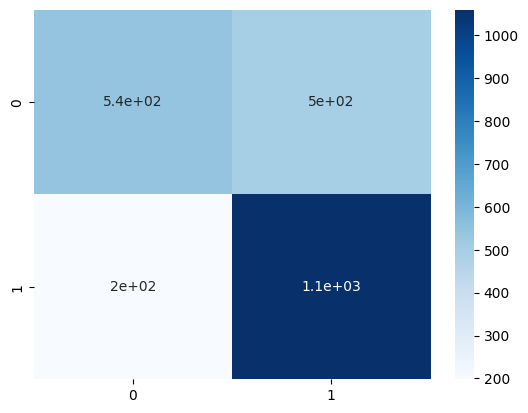

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, yhat)
sns.heatmap(cm, annot=True, cmap='Blues')
